In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from sklearn.feature_selection import SelectPercentile, mutual_info_classif
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score

In [2]:
filepath = '/kaggle/input/heart-disease-cleveland-uci/heart_cleveland_upload.csv'
df = pd.read_csv(filepath)

In [3]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,2.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,0.602694,0.676768,0.835017,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,0.956690,0.499340
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [5]:
target_col = 'condition'
df[target_col].value_counts()

0    160
1    137
Name: condition, dtype: int64

In [6]:
df.duplicated().any()

False

Нет пропущенных и null значений, дублирования тоже нет, датасет сбалансированный.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'cp'}>,
        <AxesSubplot:title={'center':'trestbps'}>],
       [<AxesSubplot:title={'center':'chol'}>,
        <AxesSubplot:title={'center':'fbs'}>,
        <AxesSubplot:title={'center':'restecg'}>,
        <AxesSubplot:title={'center':'thalach'}>],
       [<AxesSubplot:title={'center':'exang'}>,
        <AxesSubplot:title={'center':'oldpeak'}>,
        <AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'ca'}>],
       [<AxesSubplot:title={'center':'thal'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

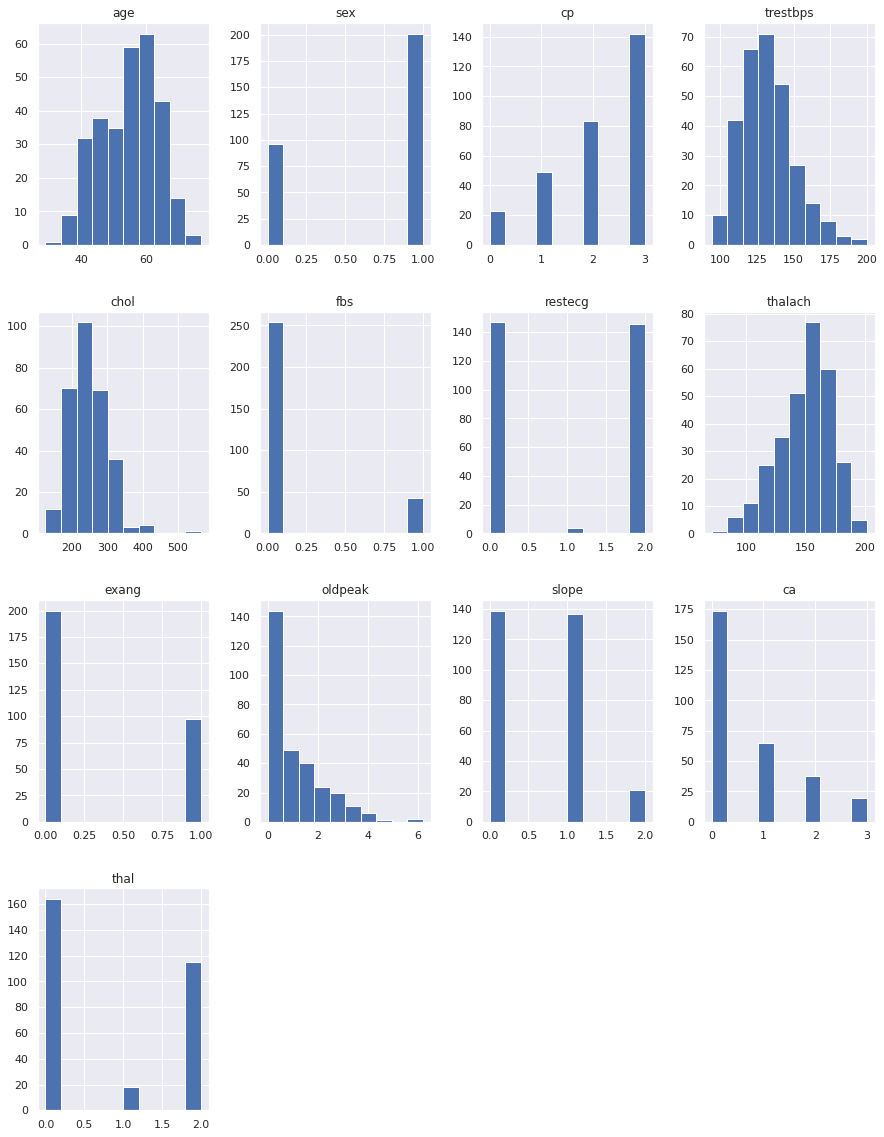

In [7]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()

df.drop(target_col, axis=1).hist(ax=ax, bins=10)

Все понятно, кроме `oldpeak` крайних значений. Из описания: oldpeak = ST depression induced by exercise relative to rest. Ноль - значит нет данных? 

In [8]:
categorical_feats = []
numeric_feats = []
for col in df.drop(target_col, axis=1).columns:
    if df[col].nunique() < 10:
        categorical_feats.append(col)
    else:
        numeric_feats.append(col)
print(categorical_feats)
print(numeric_feats)

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


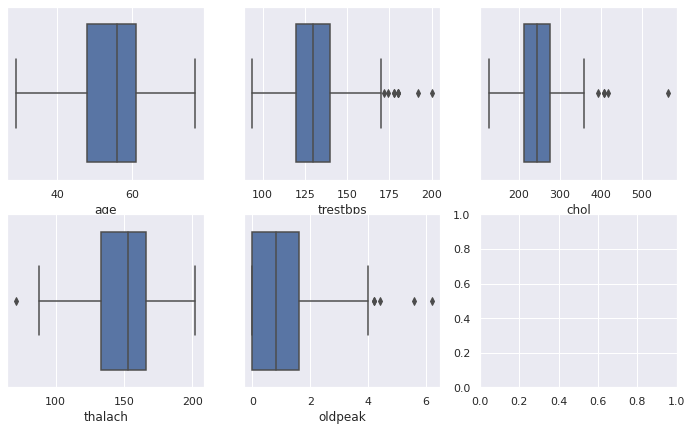

In [9]:
fig, axes = plt.subplots(round(len(numeric_feats) / 3), 3, figsize=(12, 7))
for col, ax in zip(numeric_feats, fig.axes):
    sns.boxplot(x=col, data=df, ax=ax)
    

Есть outliers. 

<AxesSubplot:>

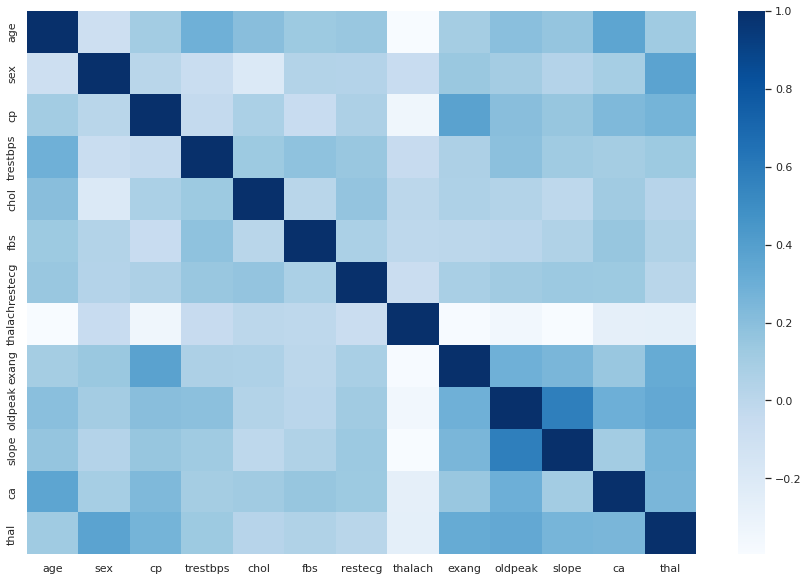

In [10]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
corr_df = df.drop(target_col, axis=1).corr()
sns.heatmap(corr_df, cmap="Blues", ax=ax)

???

In [11]:
df_corr = df.corr()[target_col][:-1]
df_corr.sort_values(ascending=False)

thal        0.520516
ca          0.463189
oldpeak     0.424052
exang       0.421355
cp          0.408945
slope       0.333049
sex         0.278467
age         0.227075
restecg     0.166343
trestbps    0.153490
chol        0.080285
fbs         0.003167
thalach    -0.423817
Name: condition, dtype: float64

In [12]:
df_corr = df[((df.oldpeak > 0) & (df.oldpeak < 6))].corr()[target_col][:-1]
df_corr.sort_values(ascending=False)

thal        0.534866
ca          0.440068
exang       0.434778
cp          0.413820
oldpeak     0.404532
sex         0.328976
slope       0.280672
age         0.143945
restecg     0.139152
trestbps    0.078694
chol        0.045930
fbs         0.026382
thalach    -0.412771
Name: condition, dtype: float64

In [13]:
df_corr = df[(df.chol < 350)].corr()[target_col][:-1]
df_corr.sort_values(ascending=False)

thal        0.514692
ca          0.453839
oldpeak     0.421895
exang       0.420871
cp          0.411522
slope       0.327939
sex         0.274551
age         0.243731
restecg     0.176933
trestbps    0.155595
chol        0.123760
fbs         0.010355
thalach    -0.422887
Name: condition, dtype: float64

cp          0.148618
thal        0.136705
ca          0.096357
chol        0.075059
oldpeak     0.070485
slope       0.068501
thalach     0.066658
exang       0.052501
sex         0.027654
trestbps    0.006857
fbs         0.000951
age         0.000000
restecg     0.000000
Name: MI Scores, dtype: float64


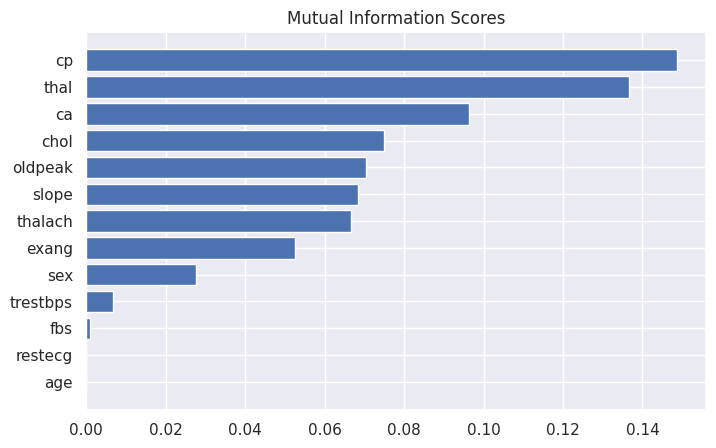

In [14]:


def make_mi_scores(X, y, features):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(df.drop(target_col, axis=1), df[target_col], numeric_feats + categorical_feats)
  # show a few features with their MI scores
    
print(mi_scores)

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

<Figure size 800x500 with 0 Axes>

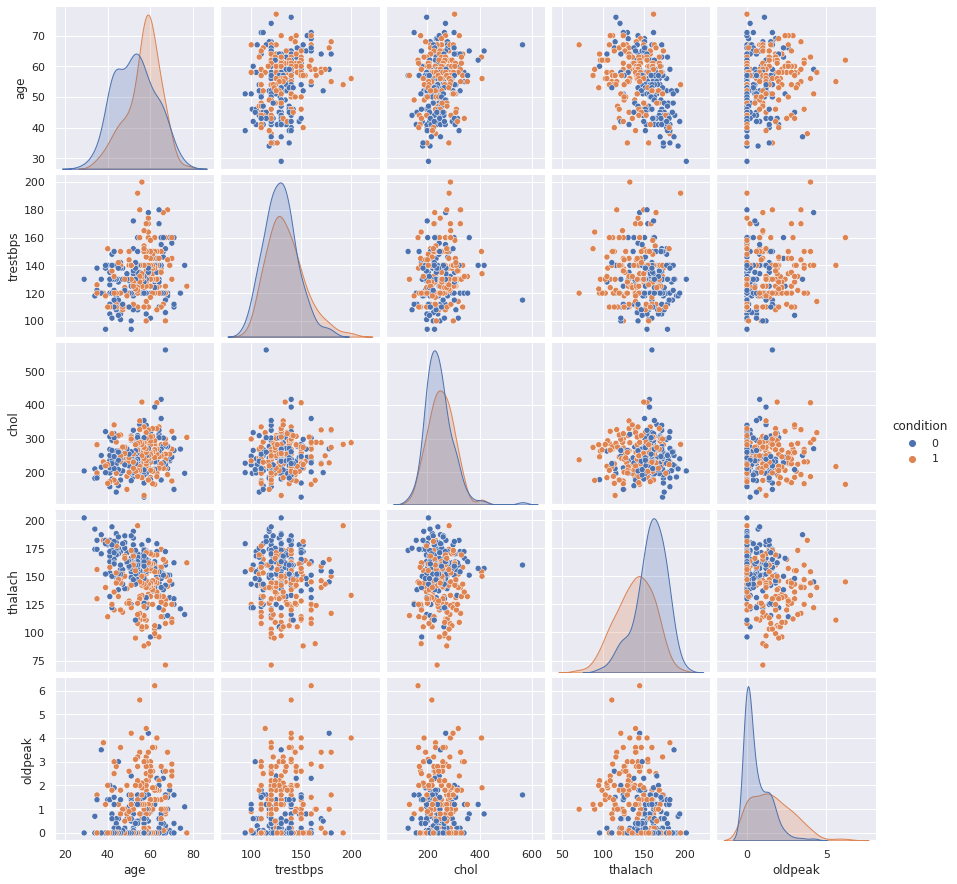

In [15]:
fig = plt.figure(dpi=100, figsize=(8, 5))
sns.pairplot(df[numeric_feats + [target_col]], hue=target_col)

Красиво и ничего непонятно.

TODO: correlation with target; difference that and mi

In [16]:
def clean_data(X):
    X.drop(X[((X.oldpeak > 0) & (X.oldpeak < 6))].index)
    return X


def preprocess_data(X):
    clean_data(X)
    return train_test_split(X.drop(target_col, axis=1), 
                            X[target_col], 
                            test_size=0.2, 
                            random_state=42) 

In [17]:
X_train, X_valid, y_train, y_valid = preprocess_data(df)

In [18]:
def make_model_rf(X, y, params):
    clf = RandomForestClassifier(**params)
    clf.fit(X, y)
    return clf


In [19]:
def get_scores_rf(X, y, params):
    random_forest_m1 = RandomForestClassifier(**params)
    scores = cross_val_score(random_forest_m1, X, y, cv=3, scoring='f1_macro')
    return scores
    
params = {'max_depth': 2, 'random_state': 0}

In [20]:
get_scores_rf(X_train, y_train, params)

array([0.8974026 , 0.83373806, 0.8081593 ])